In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# If using TFP optimizers
#!pip install -U tensorflow_probability==0.8.0

In [0]:
!git clone https://github.com/FlamTeam/flamedisx.git

%cd flamedisx
!git checkout force_interval_to_end
!git pull origin force_interval_to_end
!python setup.py develop
%cd ..

fatal: destination path 'flamedisx' already exists and is not an empty directory.
/content/flamedisx
Already on 'force_interval_to_end'
Your branch is up to date with 'origin/force_interval_to_end'.
From https://github.com/FlamTeam/flamedisx
 * branch            force_interval_to_end -> FETCH_HEAD
Already up to date.
running develop
running egg_info
writing flamedisx.egg-info/PKG-INFO
writing dependency_links to flamedisx.egg-info/dependency_links.txt
writing requirements to flamedisx.egg-info/requires.txt
writing top-level names to flamedisx.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'flamedisx.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.6/dist-packages/flamedisx.egg-link (link to .)
flamedisx 0.3.1 is already the active version in easy-install.pth

Installed /content/flamedisx
Processing dependencies for flamedisx==0.3.1
Searching for iminuit==1.3.8
Best match: iminuit 1.3.8
Processing iminuit-1.3.8-py3.6-linux-x86

In [0]:
import tensorflow as tf
tf.__version__, tf.test.is_built_with_gpu_support(), tf.test.is_gpu_available()

('2.0.0', True, True)

In [0]:
import pandas as pd
np = pd.np
import flamedisx as fd
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
from multihist import Histdd
from collections import defaultdict
import pickle

%matplotlib inline

In [0]:
# Restart runtime if this says: <module 'flamedisx' (namespace)>
fd

<module 'flamedisx' from '/content/flamedisx/flamedisx/__init__.py'>

In [0]:
#ul_guess = bf.copy()
#wrm_guess = max(1.5, 3 * bf['wimp_rate_multiplier'])
#ul_guess['wimp_rate_multiplier'] = wrm_guess

#def t_stat(wimp_rate_multiplier):
#    return -2 * (lf(er_rate_multiplier=bf['er_rate_multiplier'],
#                    wimp_rate_multiplier=wimp_rate_multiplier)
#                 - ll_best)

#while t_stat(wrm_guess) < self.crit_val:
#    wrm_guess += 0.5
#    print(f'increasing ul_guess to {wrm_guess}')
#ul_guess['wimp_rate_multiplier'] = wrm_guess

In [0]:
class Sensitivity:
    def __init__(self,
                 #mwimp=2e2,  # WIMP mass
                 #xsec=4.7e-47,  # cm^2 xsec to use
                 #n_spectra=1,  # Number of WIMP spectra to use
                 #e_rec_max=50.,  # Max recoil energy in WIMP spectra [keV]
                 #batch_size=700,  # Number of events per batch in each source
                 #max_sigma=4,
                 load_hists=None,
                 **kwargs,
                 ):
        # Calculate radius of detector volume
        #r = fd.LXeSource.tpc_radius
        #l = fd.LXeSource.tpc_length
        #v_xe1t = np.pi * r ** 2 * l
        #v_small = v_xe1t / 2 * fv
        #r_small = (v_small / l / np.pi)**0.5
        #print(f'TPC with radius {r_small :.3g} cm holds {fv} tonnes LXe')

        self.config = c = dict(
            exposure_tonneyear=1,
            er_pertonneyearkev=82.,
            max_r=38.6,             # 1.3t FV. Only controls correction amplitudes, not total exposure.
            mw=200.,              # WIMP Mass to compute limits for
            true_xsec=0.,           # True cross-section to use
            reference_xsec=4.7e-47,   # Reference cross-section (used when rate_multiplier = 1)
            n_modulation_spectra=12, # Number of WIMP spectra to compute spaced throughout time
            e_max_nr = 50.,    # Max recoil energy to consider in WIMP spectra [keV]
            e_max_er = 10.,        # Max recoil energy to consider in ER spectra [keV]
            batch_size=700,  # if have_gpu else 20,
            max_sigma=4,
            n_er_energies=1000,    # Number of ER energy points to generate
            n_wimp_energies=100,   # Number of WIMP energy points to generate
        )

        c.update(kwargs)
        assert c['n_modulation_spectra'] > 0
        assert c['exposure_tonneyear'] == 1
            
        class myERSource(fd.SR0ERSource):
            tpc_radius = c['max_r']

            def _single_spectrum(self):
                n = c['n_er_energies']
                er_perkev = c['er_pertonneyearkev'] * c['exposure_tonneyear']
                er_perpoint = er_perkev / (n / c['e_max_er'])
                return (tf.dtypes.cast(
                            tf.linspace(0., c['e_max_er'], n),
                            dtype=fd.float_type()),
                        er_perpoint * tf.ones(n, dtype=fd.float_type()))
        
        class myWIMPSource(fd.SR0WIMPSource):
            tpc_radius = c['max_r']
    
            # WIMP settings
            es = np.geomspace(0.7, c['e_max_nr'], c['n_wimp_energies'])
            mw = c['mw']
            sigma_nucleon = c['reference_xsec']
            n_in = 2

            #def __init__(self, *args, **kwargs):
            #    super().__init__(*args, **kwargs)
            #    # Energy histogram is in events / (tonne year), so multiply by exposure:

            #    ### DOES NOT WORK, populate tensor cache is already called so has no effect
            #    self.energy_hist *= c['exposure_tonneyear']
        
        class myWIMPModulationSource(myWIMPSource):
            n_in = c['n_modulation_spectra'] + 1
        
        self.lf = fd.LogLikelihood(sources=dict(er=myERSource,
                                                wimp=myWIMPSource),
                                   free_rates=('er', 'wimp'),
                                   max_sigma=c['max_sigma'],
                                   batch_size=c['batch_size'])
        
        self.lf_mod = fd.LogLikelihood(sources=dict(er=myERSource,
                                                    wimp=myWIMPModulationSource),
                                       free_rates=('er', 'wimp'),
                                       max_sigma=c['max_sigma'],
                                       batch_size=c['batch_size'])
        
        self.histograms = dict()
        if load_hists is not None:
            with open(load_hists, 'rb') as f:
                hist_dict = pickle.load(f)
            hist_ref_xsec = 4.7e-47
            print(f"scaling hist by {c['reference_xsec'] / hist_ref_xsec}")
            hist_dict['wimp'] = hist_dict['wimp'] * c['reference_xsec'] / hist_ref_xsec
            self.histograms = hist_dict

        else:
            print("building histograms")
            self.build_histograms()

        #mu_er = self.lf.sources['er'].mu_before_efficiencies()  # ??
        #mu_wimp = self.lf.sources['wimp'].mu_before_efficiencies()  # ??
        
        class myERColumn(fd.ColumnSource):
            m = self.histograms['er']
            mu = (m * m.bin_volumes()).n #* 1.389
            #mu = mu_er
            column = 'er_diff_rate'
        
        class myWIMPColumn(fd.ColumnSource):
            m = self.histograms['wimp']
            mu = (m * m.bin_volumes()).n #* 1.389
            #mu = mu_wimp
            column = 'wimp_diff_rate'
        
        self.lf_classical = fd.LogLikelihood(sources=dict(er=myERColumn,
                                                          wimp=myWIMPColumn),
                                             free_rates=('er', 'wimp'),
                                             max_sigma=c['max_sigma'],
                                             batch_size=c['batch_size'])
        
        # set true rate multipliers such that mean number of
        # ER events is about 627 and WIMP events is about 3.56
        #self.er_rate_true = 627 / self.lf.sources['er'].estimate_mu()
        #self.wimp_rate_true = 3.56 / self.lf.sources['wimp'].estimate_mu()
        #print(f"True rate multipliers: ER {self.er_rate_true :.3g},"
        #      f" NR {self.wimp_rate_true :.3g}")

        # UL only
        self.crit_val = scipy.stats.norm.ppf(0.9) ** 2
    
    @staticmethod
    def annotate_cs(d):
        d['cs1'] = (0.142 / (1 + 0.219)) * d['s1'] / (
            d['photon_detection_eff'] * d['photon_gain_mean'])
        d['cs2'] = (11.4 / (1 - 0.63) / 0.96) * d['s2'] / (
            d['electron_detection_eff'] * d['electron_gain_mean'])
    
    def build_histograms(self):
        for dname, q in self.lf.sources.items():
            mh = Histdd(bins=(
                np.linspace(0, 90, 91 + 1),
                np.geomspace(10**1.7 / (1 - 0.63),
                            10**3.9 / (1 - 0.63), 
                            70)
            ))
            
            # Actually 40 gives pretty good results already, but let's do it right
            n_batches = 100 if dname == 'er' else 40
            trials_per_batch = int(1e6)
            
            for _ in tqdm(range(n_batches)):
                d = q.simulate(trials_per_batch)
                self.annotate_cs(d)
                mh.add(d['cs1'], d['cs2'])
            
            # Convert to PDF
            mh /= mh.bin_volumes() * trials_per_batch * n_batches

            # Multiply by total expected event rate
            # (from the source, i.e. before correcting for efficiencies)
            mh *= q.mu_before_efficiencies()
            self.histograms[dname] = mh

    def ll_check(self, lf, bf, ll_best=None):
        if ll_best is None:
            ll_best = lf(**bf)
    
        xs = np.linspace(0.0, 3.5, 50)
        ys = np.array([lf(wimp_rate_multiplier=x,
                          er_rate_multiplier=bf['er_rate_multiplier'])
                       for x in xs])
        return dict(xs=xs, ys=ys, ll_best=ll_best)

    def toymc(self, do_ll_check=False):
        # simulate background only data
        # doesn't matter if simulate from lf or lf_mod since no wimps

        d = self.lf_mod.simulate(wimp_rate_multiplier=self.config['true_xsec']/self.config['reference_xsec'])
        
        self.annotate_cs(d)

        bes = self.histograms['er'].bin_edges
        mask = (
            (bes[0][0] < d['cs1']) & (d['cs1'] < bes[0][-1]) &
            (bes[1][0] < d['cs2']) & (d['cs2'] < bes[1][-1])
        )
        print(f"Throwing out {100 * (~mask).sum() / len(d):.2f}% of events")
        d = d[mask].copy()

        self.lf.set_data(d.copy())
        self.lf_mod.set_data(d.copy())

        for dname, q in self.histograms.items():
            d[f'{dname}_diff_rate'] = q.lookup(d['cs1'], d['cs2'])

        self.lf_classical.set_data(d.copy())

        guess = dict(er_rate_multiplier=0.9,
                     wimp_rate_multiplier=0.1)
        
        fit_fd = self.fit_toy(guess, self.lf, do_ll_check=do_ll_check)
        fit_mod = self.fit_toy(guess, self.lf_mod, do_ll_check=do_ll_check)
        fit_classical = self.fit_toy(guess, self.lf_classical, do_ll_check=do_ll_check)

        return fit_fd, fit_mod, fit_classical
    
    def fit_toy(self, guess, lf, do_ll_check=False):
        # Determine the global best fit
        bf = lf.bestfit(guess=guess, llr_tolerance=0.0001)
        ll_best = lf(**bf)
    
        ul = lf.limit('wimp_rate_multiplier', bestfit=bf, tol_multiplier=3e-4)

        check = dict()
        if do_ll_check:
            check = self.ll_check(lf, bf, ll_best=ll_best)
        
        return {**bf, **check,
                'ul': ul,}
                #'ul_guess': ul_guess['wimp_rate_multiplier']}
        
    def run_toys(self, n, do_ll_check=False, df=True, save_name=None):
        res = np.array([self.toymc(do_ll_check=do_ll_check)
                        for _ in tqdm(range(n))])
        
        if df or save_name is not None:
            d = defaultdict(list)
            for toy in res:
                for k, v in toy.items():
                    d[k].append(v)
            res_df = pd.DataFrame(d)
        
        if save_name is not None:
            res_df.to_pickle(save_name)
        
        if df:
            return res_df
        return res
    
    def sim_set_and_call(self):
        d = self.lf.simulate(wimp_rate_multiplier=0.)
        self.lf.set_data(d)

        lnL = self.lf()
        return d, lnL
    
    def load(self, names):
        dfs = []
        for name in names:
            dfs.append(pd.read_pickle(name))
        return pd.concat(dfs, sort=False).reset_index(drop=True)
    
    def save_histograms(self, save_name):
        if not save_name.endswith('.pkl'):
            save_name += '.pkl'
        with open(save_name, 'wb') as f:
            pickle.dump(self.histograms, f)
    
    def plot_histograms(self):
        for dname, q in self.histograms.items():
            q.plot(cblabel='rate * PDF')
            plt.title(dname)
            plt.yscale('log')
            plt.xlabel("cS1 [PE]")
            plt.ylabel("cS2 [PE]")
            plt.show()

In [0]:
mu_test = np.array([sensitivity.lf.sources['er'].estimate_mu()
                    for _ in tqdm(range(100))])

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [0]:
mu_test.mean()

627.1160273217957

(array([ 3.,  4., 11., 10., 20., 17., 14., 10.,  8.,  3.]),
 array([624.50375352, 625.01707348, 625.53039344, 626.0437134 ,
        626.55703336, 627.07035333, 627.58367329, 628.09699325,
        628.61031321, 629.12363317, 629.63695313]),
 <a list of 10 Patch objects>)

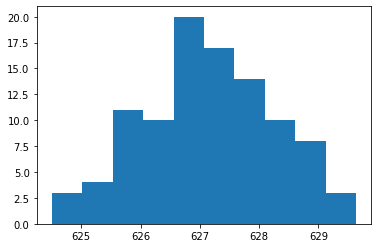

In [0]:
plt.hist(mu_test)

In [0]:
mu_s = sensitivity.lf.sources['er'].mu_before_efficiencies()
        
m = sensitivity.histograms['er']
mu = (m * m.bin_volumes()).n

print(mu_s)
print(mu)
print(mu_s/mu)

819.99994
626.9969715306573
1.3078212115810028


In [0]:
sensitivity.histograms['er'].n

1.8933429594252627

In [0]:
sensitivity.lf_classical.sources['er'].mu_before_efficiencies()

626.9969715306573

# Setup sensitivity

In [0]:
sensitivity = Sensitivity(
    #fv=1.3,  # FV to use (approx, just shrinking radius of Xe1T)
    #mwimp=2e2,  # WIMP mass
    #xsec=4.7e-47,  # cm^2 xsec to use
    #n_spectra=12,  # Number of WIMP spectra to use
    #e_rec_max=50.,  # Max recoil energy in WIMP spectra [keV]
    batch_size=700,  # Number of events per batch in each source
    max_sigma=3,
    load_hists=None, #"histograms_200GeV_ms4_s1_80pe_sr0_ermax10_mu.pkl",
    )

Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

building histograms


100%|██████████| 40/40 [06:21<00:00,  9.53s/it]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]


In [0]:
sensitivity.save_histograms("histograms_200GeV_ms3_s1_90pe_sr0_ermax10")

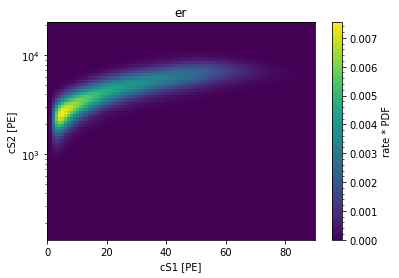

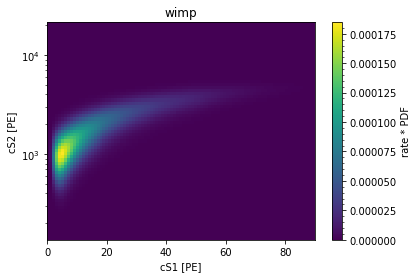

In [0]:
sensitivity.plot_histograms()

# Run toyMCs

In [0]:
%%time
# Set some data and call likelihood, this will trigger the tracing (takes about 7 seconds)
a, b = sensitivity.sim_set_and_call()
print(len(a), b)

618 -3825.683
CPU times: user 12.8 s, sys: 1.52 s, total: 14.3 s
Wall time: 15 s


In [0]:
%%time
# Now calling likelihood should be fast (~250 ms)
sensitivity.lf()

CPU times: user 52.3 ms, sys: 14.2 ms, total: 66.5 ms
Wall time: 265 ms


-3825.683

In [0]:
res = []

In [0]:
res0 = np.array([sensitivity.toymc(do_ll_check=False) for _ in tqdm(range(20))])

  0%|          | 0/20 [00:00<?, ?it/s]

Throwing out 0.00% of events


  5%|▌         | 1/20 [01:05<20:46, 65.63s/it]

Throwing out 0.00% of events


 10%|█         | 2/20 [02:37<22:02, 73.45s/it]

Throwing out 0.00% of events


 15%|█▌        | 3/20 [04:21<23:27, 82.77s/it]

Throwing out 0.00% of events


 20%|██        | 4/20 [06:06<23:48, 89.27s/it]

Throwing out 0.00% of events


 25%|██▌       | 5/20 [07:42<22:48, 91.22s/it]

Throwing out 0.00% of events


 30%|███       | 6/20 [09:00<20:23, 87.38s/it]

Throwing out 0.00% of events


 35%|███▌      | 7/20 [10:10<17:48, 82.22s/it]

Throwing out 0.00% of events


 40%|████      | 8/20 [11:32<16:26, 82.24s/it]

Throwing out 0.00% of events


 45%|████▌     | 9/20 [13:10<15:55, 86.84s/it]

Throwing out 0.00% of events


 50%|█████     | 10/20 [14:37<14:29, 86.94s/it]

Throwing out 0.00% of events


 55%|█████▌    | 11/20 [16:03<12:59, 86.62s/it]

Throwing out 0.00% of events


 60%|██████    | 12/20 [17:08<10:40, 80.00s/it]

Throwing out 0.00% of events


 65%|██████▌   | 13/20 [18:38<09:41, 83.13s/it]

Throwing out 0.00% of events


 70%|███████   | 14/20 [20:13<08:40, 86.71s/it]

Throwing out 0.00% of events


 75%|███████▌  | 15/20 [21:34<07:05, 85.09s/it]

Throwing out 0.00% of events


 80%|████████  | 16/20 [22:56<05:35, 83.96s/it]

Throwing out 0.00% of events


 85%|████████▌ | 17/20 [23:55<03:49, 76.53s/it]

Throwing out 0.00% of events


 90%|█████████ | 18/20 [24:54<02:22, 71.33s/it]

Throwing out 0.00% of events


 95%|█████████▌| 19/20 [26:25<01:17, 77.18s/it]

Throwing out 0.00% of events


100%|██████████| 20/20 [28:09<00:00, 85.38s/it]


In [0]:
res = np.array(list(res) + list(res0))

In [0]:
len(res)

170

In [0]:
for ll in [sensitivity.lf, sensitivity.lf_mod, sensitivity.lf_classical]:
    s = ll.sources['wimp']
    print('n_padding', s.n_padding)
    print('n_batches', s.n_batches)
    print('n_events', s.n_events)
    print('batch_size', s.batch_size)
    print('len data', len(s.data))
    print('data tensor shape', s.data_tensor.shape)
    print('batch data tensor shape', s._batch_data_tensor_shape())
    print(' ')
#sensitivity.lf_classical.batch_size  #lf.sources['wimp'].n_batches

n_padding 71
n_batches 1
n_events 629
batch_size 700
len data 700
data tensor shape (1, 700, 109)
batch data tensor shape [700, 109]
 
n_padding 71
n_batches 1
n_events 629
batch_size 700
len data 700
data tensor shape (1, 700, 109)
batch data tensor shape [700, 109]
 
n_padding 71
n_batches 1
n_events 629
batch_size 700
len data 700
data tensor shape (1, 700, 1)
batch data tensor shape [700, 1]
 


In [0]:
#
s = sensitivity.lf_classical.sources['er']
data = s.data[:s.n_events].copy()

data['er_diff_rate_fd'] = sensitivity.lf.sources['er'].batched_differential_rate()
data['wimp_diff_rate_fd'] = sensitivity.lf.sources['wimp'].batched_differential_rate()

100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


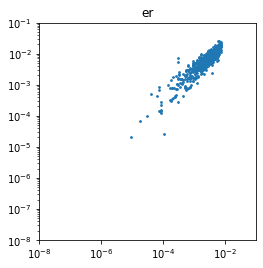

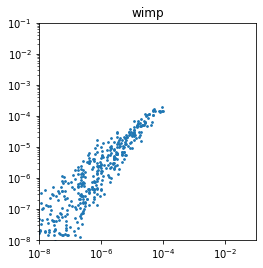

In [0]:
for d in ['er', 'wimp']:
    for idx, source in enumerate(['er', 'wimp']):
        mask = data['source'] == source
        plt.scatter(data[f'{d}_diff_rate'][mask], data[f'{d}_diff_rate_fd'][mask], c=f'C{idx}', s=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1e-8, 1e-1)
    plt.xlim(1e-8, 1e-1)
    plt.gca().set_aspect(1)
    plt.title(d)
    plt.show()

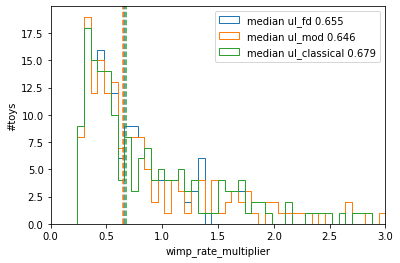

In [0]:
dd = defaultdict(list)
for (r_fd, r_mod, r_classical) in res:
    dd['ul_fd'].append(r_fd['ul'])
    dd['ul_mod'].append(r_mod['ul'])
    dd['ul_classical'].append(r_classical['ul'])
for idx, (k, v) in enumerate(dd.items()):
    dd[k] = np.array(v)
    m_ul = np.median(v)
    plt.axvline(m_ul, color=f'C{idx}', linestyle='--')
    plt.hist(dd[k], bins=50, color=f'C{idx}', range=(0, 3), histtype='step',
             label=f'median {k} {m_ul :.3g}')
plt.xlim(0, 3)
plt.legend()
plt.xlabel('wimp_rate_multiplier')
plt.ylabel('#toys')
plt.savefig('sensitivity_comp_170_ms3_90pe.png', dpi=150, bbox_inches='tight')
plt.show()

In [0]:
        def annotate_cs(d):
    d['cs1'] = (0.142 / (1 + 0.219)) * d['s1'] / (
        d['photon_detection_eff'] * d['photon_gain_mean'])
    d['cs2'] = (11.4 / (1 - 0.63) / 0.96) * d['s2'] / (
        d['electron_detection_eff'] * d['electron_gain_mean'])

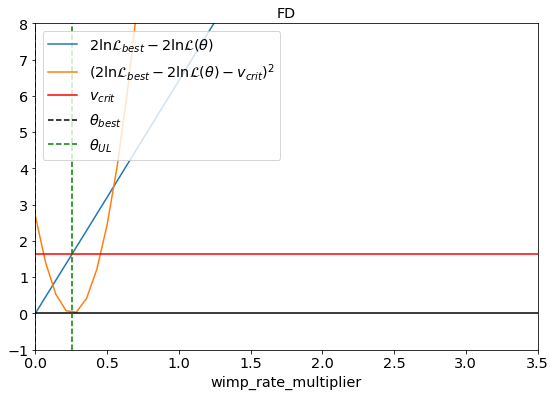

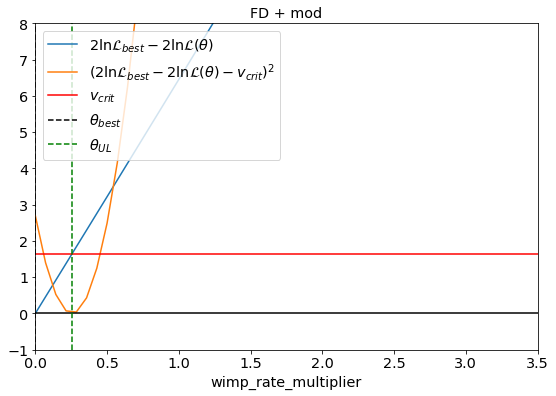

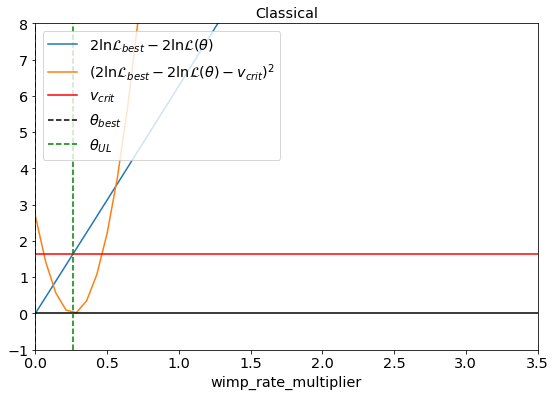

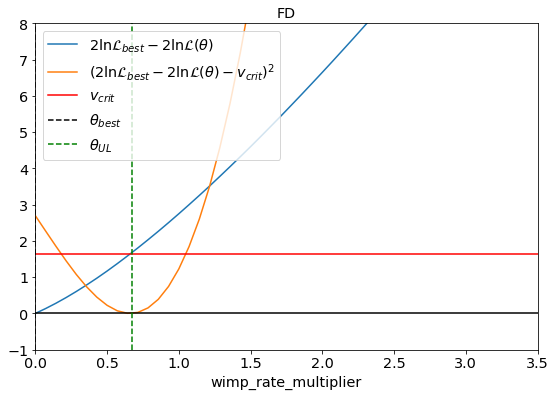

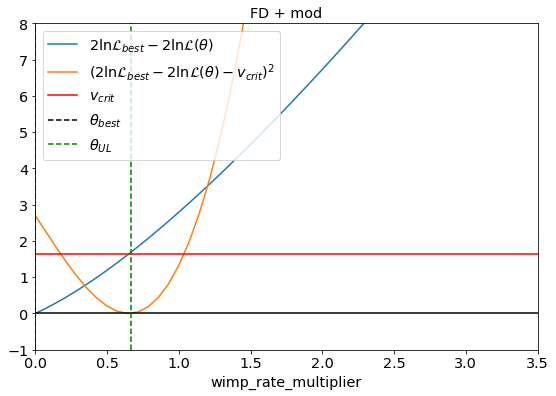

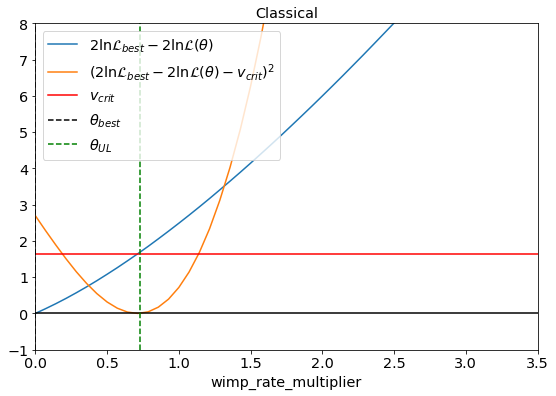

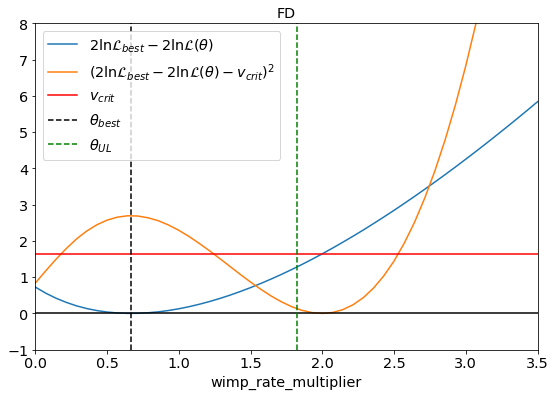

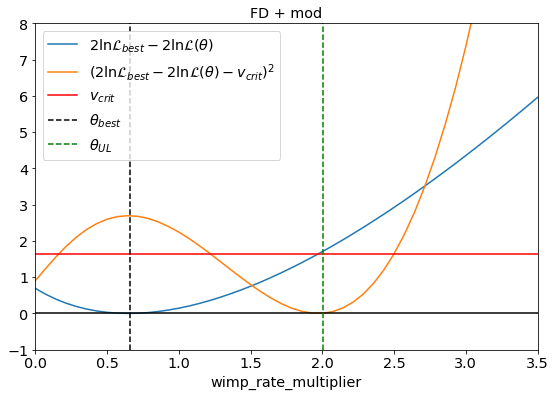

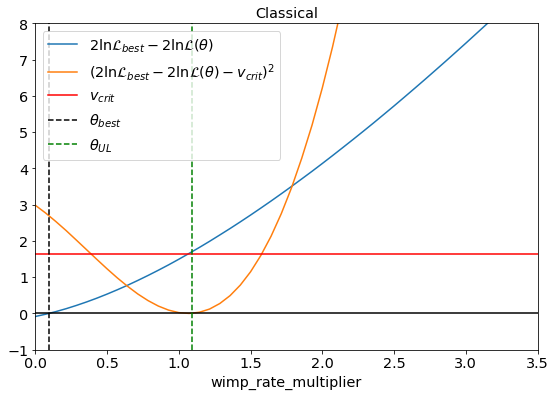

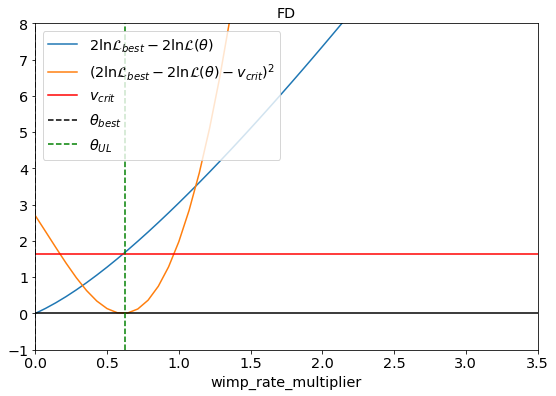

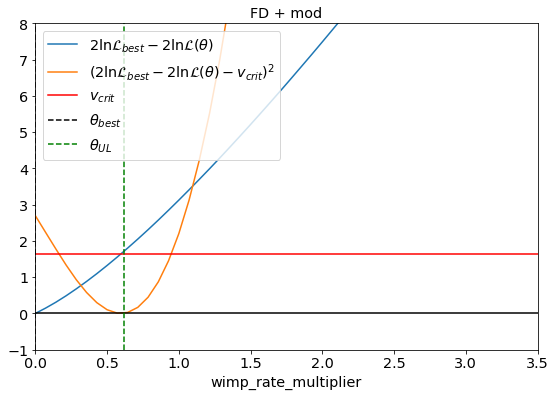

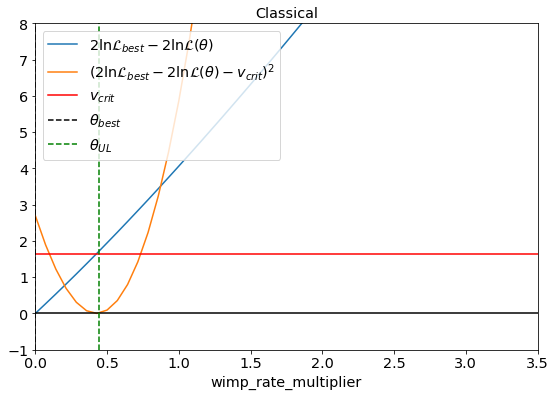

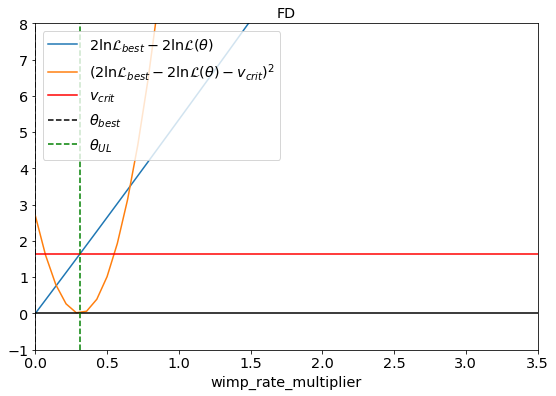

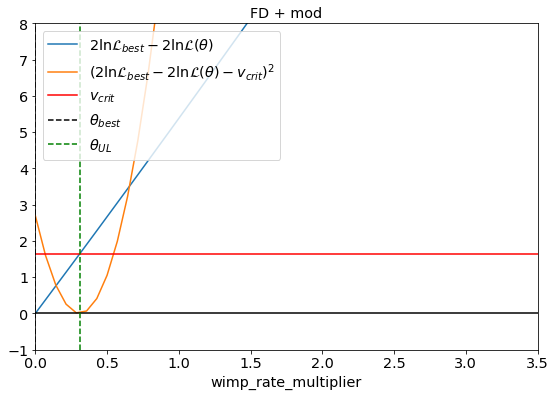

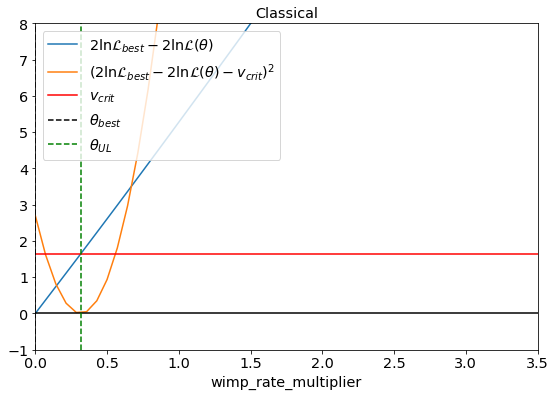

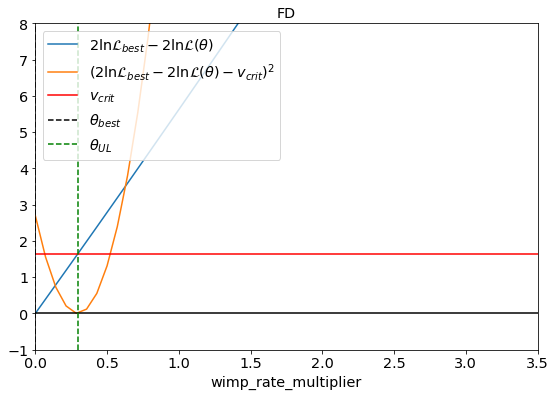

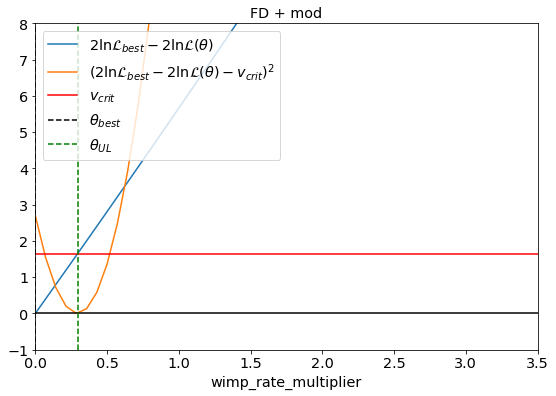

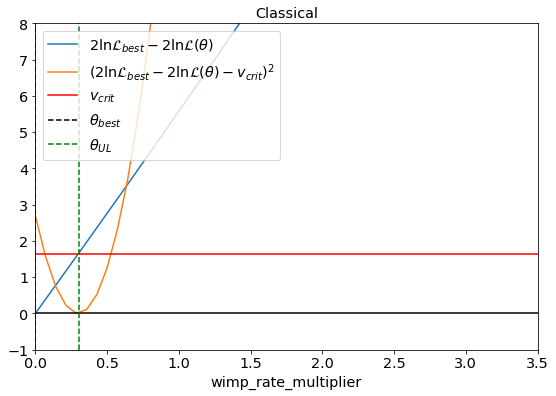

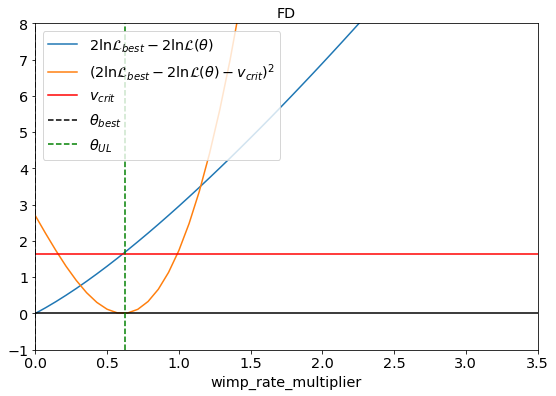

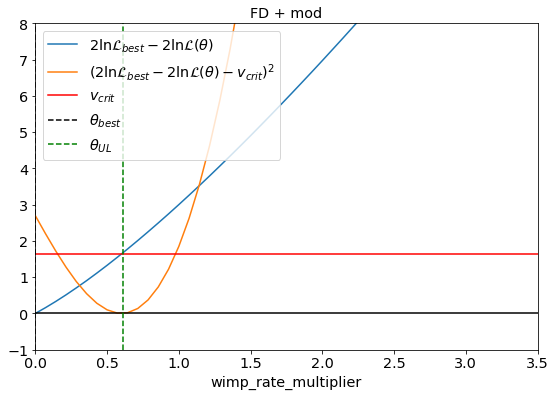

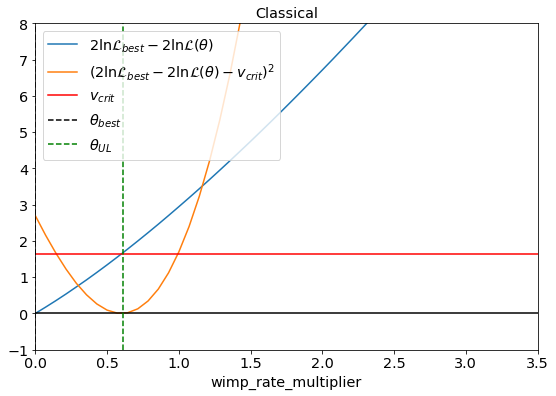

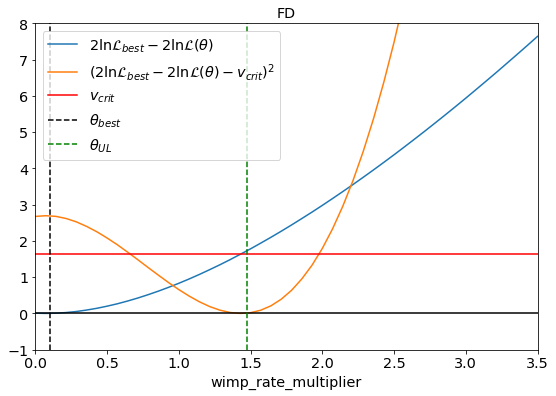

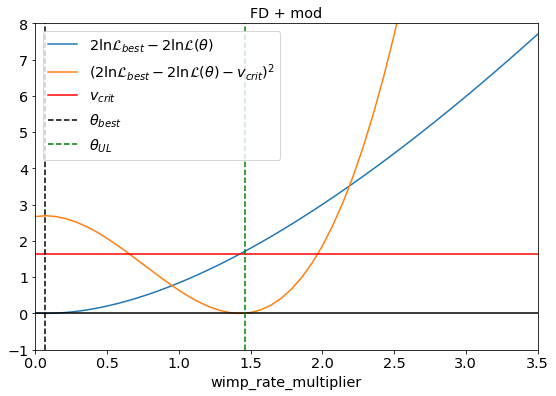

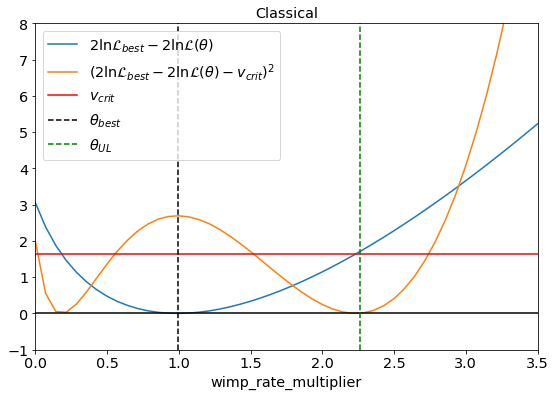

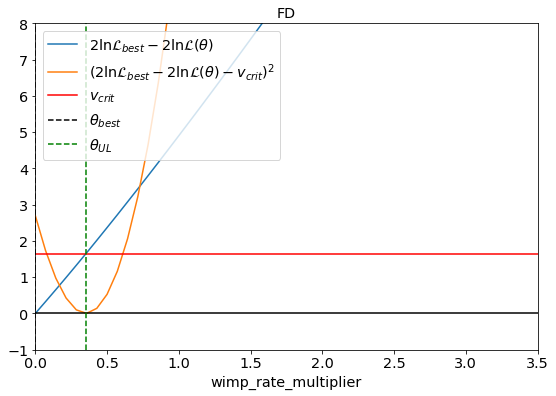

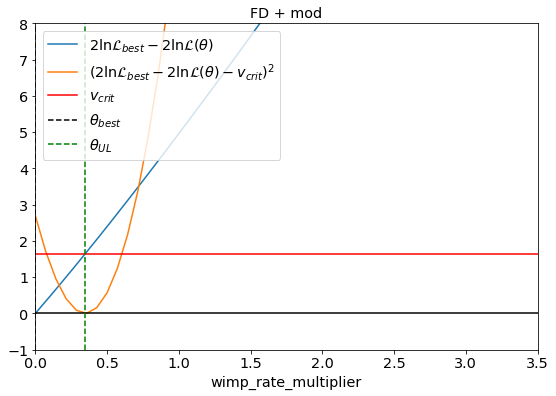

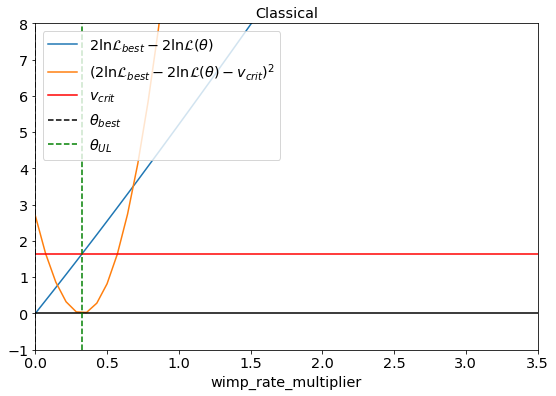

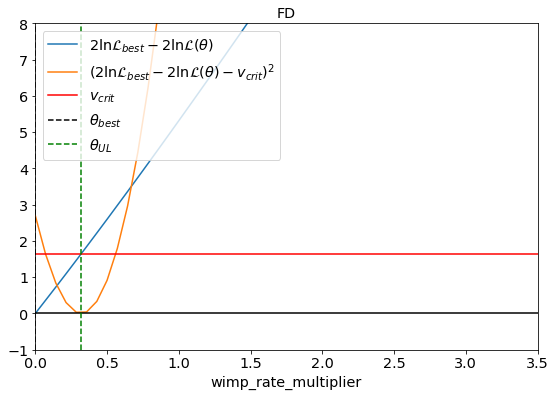

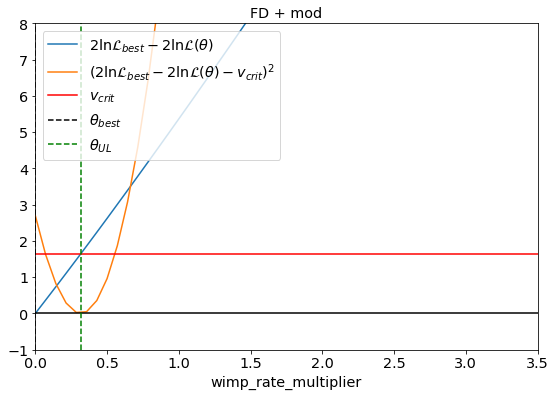

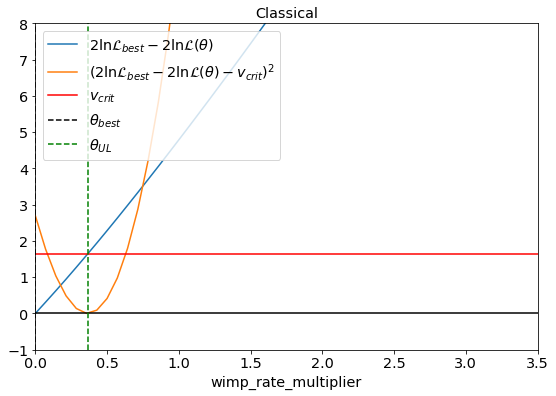

In [0]:
crit_val = scipy.stats.norm.ppf(0.9) ** 2

for (r_fd, r_mod, r_classical) in res:
    ll_plot(r_fd, title="FD")
    ll_plot(r_mod, title="FD + mod")
    ll_plot(r_classical, title="Classical")

In [0]:
res_mod

{'er_rate_multiplier': 0.761895942447267,
 'll_best': -3664.8176,
 'ul': 0.6682179690665476,
 'wimp_rate_multiplier': 1e-09,
 'xs': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
        0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
        0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ,
        1.07142857, 1.14285714, 1.21428571, 1.28571429, 1.35714286,
        1.42857143, 1.5       , 1.57142857, 1.64285714, 1.71428571,
        1.78571429, 1.85714286, 1.92857143, 2.        , 2.07142857,
        2.14285714, 2.21428571, 2.28571429, 2.35714286, 2.42857143,
        2.5       , 2.57142857, 2.64285714, 2.71428571, 2.78571429,
        2.85714286, 2.92857143, 3.        , 3.07142857, 3.14285714,
        3.21428571, 3.28571429, 3.35714286, 3.42857143, 3.5       ]),
 'ys': array([-3664.8176, -3664.8948, -3664.975 , -3665.058 , -3665.144 ,
        -3665.2327, -3665.324 , -3665.4177, -3665.5132, -3665.6113,
        -3665.7117, -3665.8145, -3665.919 , -

In [0]:
res_fd

{'er_rate_multiplier': 0.7601899207717755,
 'll_best': -3666.1873,
 'ul': 0.6841088172581832,
 'wimp_rate_multiplier': 1e-09,
 'xs': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
        0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
        0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ,
        1.07142857, 1.14285714, 1.21428571, 1.28571429, 1.35714286,
        1.42857143, 1.5       , 1.57142857, 1.64285714, 1.71428571,
        1.78571429, 1.85714286, 1.92857143, 2.        , 2.07142857,
        2.14285714, 2.21428571, 2.28571429, 2.35714286, 2.42857143,
        2.5       , 2.57142857, 2.64285714, 2.71428571, 2.78571429,
        2.85714286, 2.92857143, 3.        , 3.07142857, 3.14285714,
        3.21428571, 3.28571429, 3.35714286, 3.42857143, 3.5       ]),
 'ys': array([-3666.1873, -3666.2622, -3666.3398, -3666.4204, -3666.5042,
        -3666.5903, -3666.6794, -3666.7705, -3666.8645, -3666.9607,
        -3667.0588, -3667.1597, -3667.262 , 

In [0]:
res_classical

{'er_rate_multiplier': 0.7759065332164631,
 'll_best': -4045.2686,
 'ul': 0.7629809889631658,
 'wimp_rate_multiplier': 1e-09,
 'xs': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
        0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
        0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ,
        1.07142857, 1.14285714, 1.21428571, 1.28571429, 1.35714286,
        1.42857143, 1.5       , 1.57142857, 1.64285714, 1.71428571,
        1.78571429, 1.85714286, 1.92857143, 2.        , 2.07142857,
        2.14285714, 2.21428571, 2.28571429, 2.35714286, 2.42857143,
        2.5       , 2.57142857, 2.64285714, 2.71428571, 2.78571429,
        2.85714286, 2.92857143, 3.        , 3.07142857, 3.14285714,
        3.21428571, 3.28571429, 3.35714286, 3.42857143, 3.5       ]),
 'ys': array([-4045.2686, -4045.3267, -4045.3904, -4045.4578, -4045.5298,
        -4045.6057, -4045.685 , -4045.7683, -4045.8542, -4045.9436,
        -4046.036 , -4046.1313, -4046.229 , 

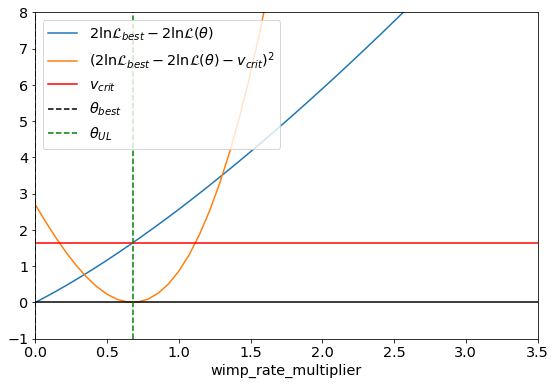

In [0]:
ll_plot(res_fd)

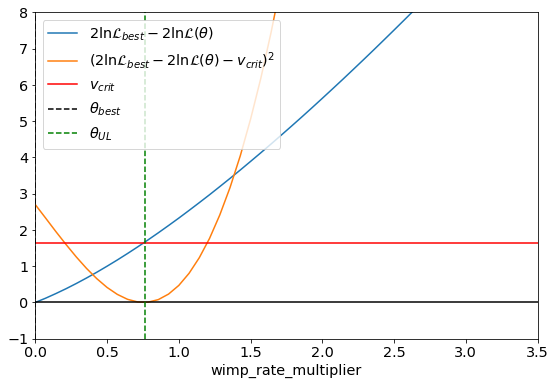

In [0]:
ll_plot(res_classical)

In [0]:
toys_df_mod = sensitivity.run_toys(200, do_ll_check=False, save_name='toys_mw20_mod.pkl')


100%|██████████| 200/200 [56:35<00:00, 15.69s/it]


# Results

In [0]:
toys_df

,er_rate_multiplier,wimp_rate_multiplier,ul,ul_guess
0,0.829603,1.000000e-09,0.214851,1.5
1,0.793444,1.000000e-09,0.034656,1.5
2,0.860272,1.000000e-09,0.271841,1.5
3,0.864312,1.000000e-09,0.175100,1.5
4,0.815542,2.320938e-01,0.737721,1.5
...,...,...,...,...
195,0.833054,1.000000e-09,0.550254,1.5
196,0.801624,1.000000e-09,0.132222,1.5
197,0.865529,1.000000e-09,0.339244,1.5
198,0.823790,1.000000e-09,0.161622,1.5


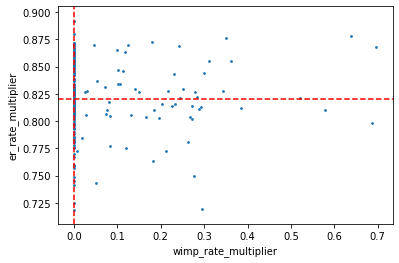

In [0]:
plt.scatter(toys_df['wimp_rate_multiplier'],
            toys_df['er_rate_multiplier'],
            s=3)
plt.axhline(sensitivity.er_rate_true, color='r', linestyle='--')
plt.axvline(0., color='r', linestyle='--')
plt.xlabel('wimp_rate_multiplier')
plt.ylabel('er_rate_multiplier')
plt.show()

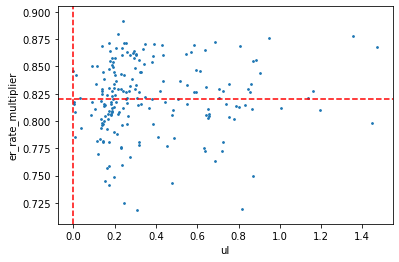

In [0]:
plt.scatter(toys_df['ul'],
            toys_df['er_rate_multiplier'],
            s=3)
plt.axhline(sensitivity.er_rate_true, color='r', linestyle='--')
plt.axvline(0., color='r', linestyle='--')
plt.xlabel('ul')
plt.ylabel('er_rate_multiplier')
plt.show()

In [0]:
chi2 = scipy.stats.chi2

In [0]:
xs = np.linspace(0, 3.5, 100)
ys = 0.5 * chi2.pdf(xs, df=1)

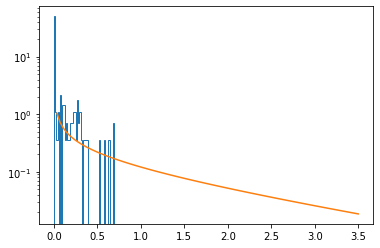

In [0]:
plt.hist(toys_df['wimp_rate_multiplier'], bins=50, density=1, histtype='step')
plt.plot(xs, ys)
#plt.ylim(0, 2)
plt.yscale('log')
plt.show()

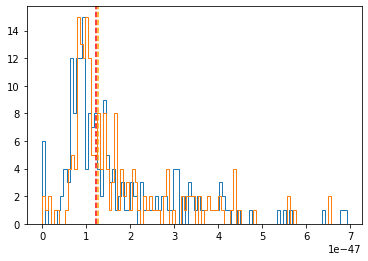

In [0]:
xsec = toys_df['ul'] * 4.7e-47
plt.hist(xsec, bins=100, histtype='step')
plt.axvline(np.median(xsec), color='r', linestyle='--')
xsec = toys_df_mod['ul'] * 4.7e-47
plt.hist(xsec, bins=100, histtype='step')
plt.axvline(np.median(xsec), color='orange', linestyle='--')
plt.show()

In [0]:
np.min(toys_df['ul']), np.median(toys_df['ul']), np.max(toys_df['ul'])

(0.0001134572288450375, 0.25977278169912743, 1.4702376776773227)

# Check lnL parabola

In [0]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [0]:
def ll_plot(data, title="", save_name=None):
    xs = data['xs']
    ys = data['ys']
    ll_best = data['ll_best']
    ul = data['ul']
    wimp_rm = data['wimp_rate_multiplier']
    er_rm = data['er_rate_multiplier']
    #ul_guess = data['ul_guess']

    plt.figure()
    plt.plot(xs, -2*(ys-ll_best), label=r'$2\ln\mathcal{L}_{best} -2\ln\mathcal{L}(\theta)$')
    plt.plot(xs, (-2*(ys-ll_best)-crit_val)**2, label=r'$(2\ln\mathcal{L}_{best} -2\ln\mathcal{L}(\theta) - v_{crit})^2$')

    plt.axhline(0, color='k')
    plt.axhline(crit_val, color='red', label=r'$v_{crit}$')

    plt.axvline(wimp_rm, color='k', linestyle='--', label=r'$\theta_{best}$')
    plt.axvline(ul, color='g', linestyle='--', label=r'$\theta_{UL}$')
    #plt.axvline(ul_guess, color='magenta', linestyle='--', label=r'$\theta_{start}$')

    plt.ylim(-1, 8)
    plt.xlim(0.0, 3.5)
    plt.xlabel('wimp_rate_multiplier')
    plt.legend(loc='upper left')
    plt.title(title)
    if save_name is not None:
        plt.savefig(save_name + '.png', dpi=200, bbox_inches='tight')
    plt.show()

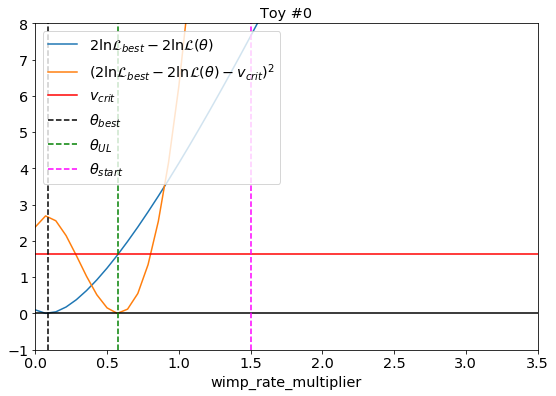

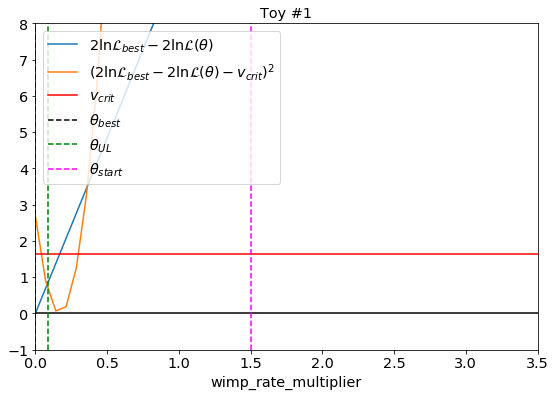

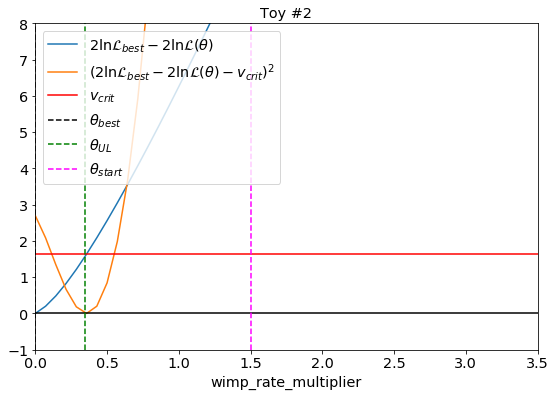

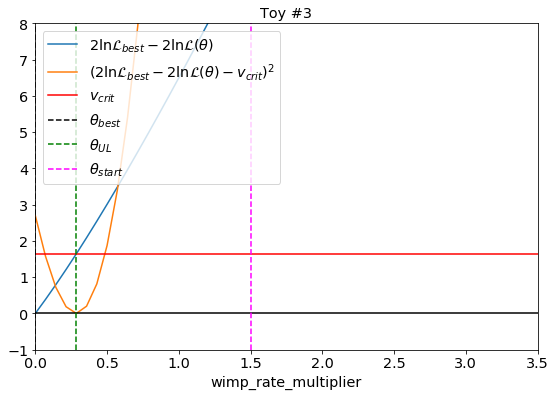

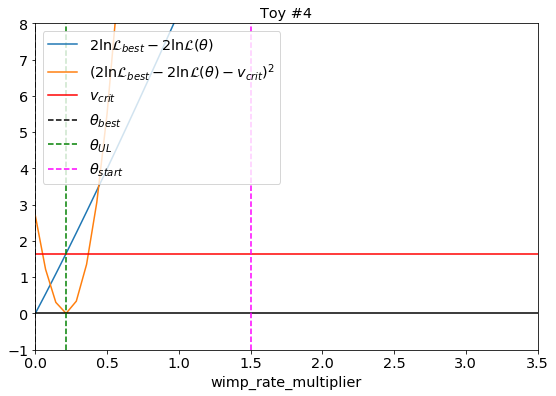

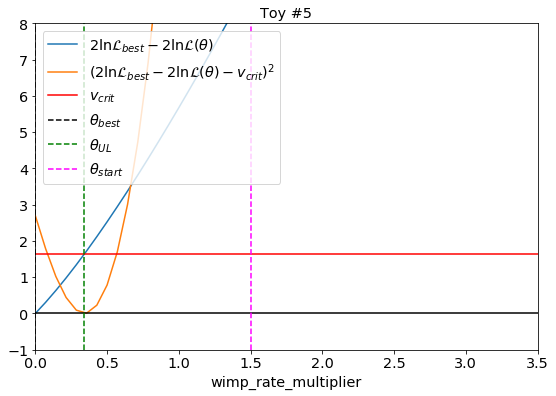

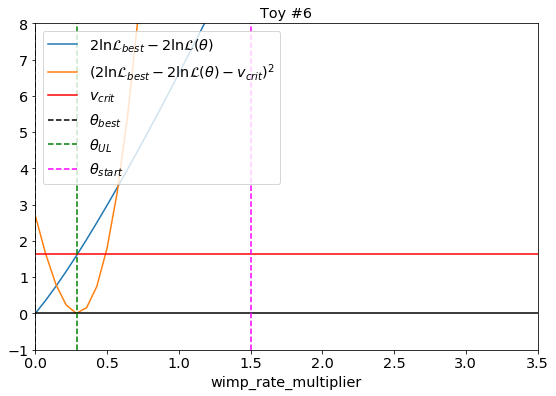

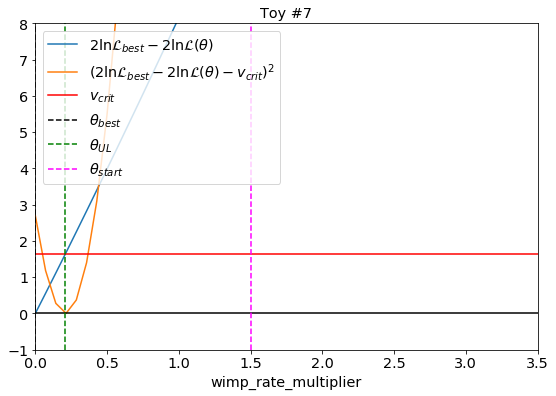

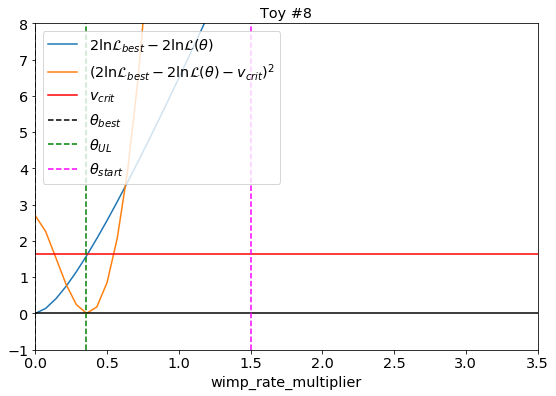

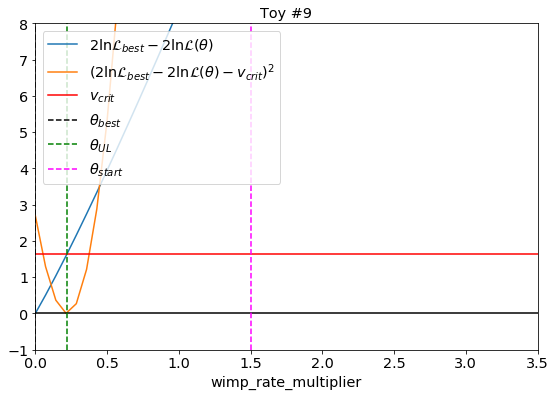

In [0]:
for idx, toy in toys_df.iterrows():
    ll_plot(toy, title=f'Toy #{idx}') # , save_name=f'toy_{idx}')